In [1]:
import ipympl
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange, tqdm_notebook
import pandas as pd
import torch
import torch.nn as nn
import random
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from datetime import datetime
import glob, os

In [2]:
env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1)
PATH = glob.glob(os.path.expanduser('~/tboardlogs/'))
writer = SummaryWriter('{}{}'.format(PATH, datetime.now().strftime('%b%d_%H-%M-%S')))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/hahamark/.local/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
import random
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        # YOUR CODE HERE
        if len(self.memory) >= self.capacity:
            self.memory.pop(0)
        self.memory.append(transition)

    def sample(self, batch_size):
        # YOUR CODE HERE
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
capacity = 10
memory = ReplayMemory(capacity)

# Sample a transition
s = env.reset()
a = env.action_space.sample()
s_next, r, done, _ = env.step(a)

# Push a transition
memory.push((s, a, r, s_next, done))

# Sample a batch size of 1
print(memory.sample(1))

[(array([-0.43852191,  0.        ]), 0, -1.0, array([-0.44015308, -0.00163117]), False)]


Furthest Position: -0.1585655553751691


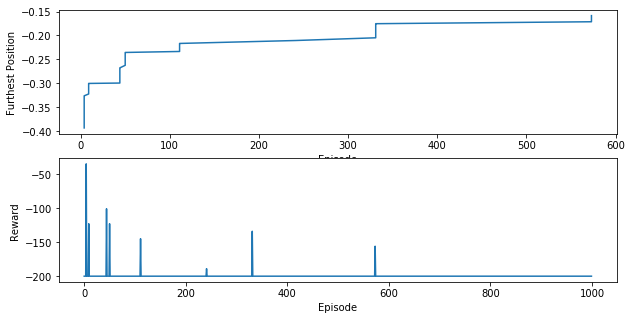

successful episodes: 0


In [5]:
max_position = -.4
positions = np.ndarray([0,2])
rewards = []
successful = []
for episode in range(1000):
    running_reward = 0
    env.reset()
    done = False
    for i in range(200):
        state, reward, done, _ = env.step(np.random.randint(0,3))
        # Give a reward for reaching a new maximum position
        if state[0] > max_position:
            max_position = state[0]
            positions = np.append(positions, [[episode, max_position]], axis=0)
            running_reward += 10
        else:
            running_reward += reward
        if done: 
            if state[0] >= 0.5:
                successful.append(episode)
            rewards.append(running_reward)
            break

print('Furthest Position: {}'.format(max_position))
plt.figure(1, figsize=[10,5])
plt.subplot(211)
plt.plot(positions[:,0], positions[:,1])
plt.xlabel('Episode')
plt.ylabel('Furthest Position')
plt.subplot(212)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('successful episodes: {}'.format(np.count_nonzero(successful)))

In [6]:
# I tried different weight initializations but found they did not perform well.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 100
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            self.l2,
        )
        return model(x)

In [30]:
def trainDQN(policy, loss_fn, memory, optimizer, batch_size, gamma):
    # random transition batch is taken from experience replay memory
    if len(memory) < batch_size:
        return None
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, state_1, done = zip(*transitions)
    
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    
    state_1 = torch.tensor(state_1, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    Q = policy(Variable(state))
    Q1 = policy(Variable(state_1))
    
    maxQ1, _ = torch.max(Q1, -1)

    # Create target Q value for training the policy
    Q_target = Q.clone()
    Q_target = Variable(Q_target)
    for a in action:
        Q_target[a, action[a]] = reward[a] + torch.mul(maxQ1[a].detach(), gamma)

    # Calculate loss
    loss = loss_fn(Q, Q_target)

    # Update policy
    policy.zero_grad()
    loss.backward()
    optimizer.step()               
    
    return loss
    
    

In [31]:
def trainDDQN(policy1, policy2, loss_fn, memory, optimizer, batch_size, gamma):
    # random transition batch is taken from experience replay memory
    if len(memory) < batch_size:
        return None
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, state_1, done = zip(*transitions)
    
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    
    state_1 = torch.tensor(state_1, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # Find max Q for t+1 state
    if turn1:
        Q1 = policy2(Variable(state_1)).detach()
        Q2 = policy1(Variable(state_1))
    else:
        Q1 = policy1(Variable(state_1)).detach()
        Q2 = policy2(Variable(state_1))

    _, a_prime = torch.max(Q1, -1)

    maxQ1 = Q2[a_prime]

    # Create target Q value for training the policy
    Q_target = Q.clone()
    Q_target = Variable(Q_target)
    for a in action:
        Q_target[a, action[a]] = reward[a] + torch.mul(maxQ1[a], gamma)

    # Calculate loss
    loss = loss_fn(Q, Q_target)

    # Update policy
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    print(loss)
    return loss

In [32]:
def DQN(episodes):
    
    # Parameters
    steps = 200
    state = env.reset()
    epsilon = 0.3
    gamma = 0.99
    loss_history = []
    reward_history = []
    learning_rate = 0.001
    successes = 0
    position = []
    memory = ReplayMemory(10000)
    batch_size = 32

    # Initialize Policy
    policy = Policy()
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    for episode in tqdm_notebook(range(episodes)):
        episode_loss = 0
        episode_reward = 0
        state = env.reset()

        for s in range(steps):
            # Get first action value function
            Q = policy(Variable(torch.from_numpy(state).type(torch.FloatTensor)))

            # Choose epsilon-greedy action
            if np.random.rand(1) < epsilon:
                action = np.random.randint(0,3)
            else:
                _, action = torch.max(Q, -1)
                action = action.item()

            # Step forward and receive next state and reward
            state_1, reward, done, _ = env.step(action)
            klaar = done

            # Adjust reward based on car position
            reward = state_1[0] + 0.5

            # Adjust reward for task completion
            if state_1[0] >= 0.5:
                reward += 1

            # Train the DQN
            memory.push((state, action, reward, state_1, done))
            loss = trainDQN(policy, loss_fn, memory, optimizer, batch_size, gamma)

            if done:
                if state_1[0] >= 0.5:
                    # On successful epsisodes, adjust the following parameters
                    # Adjust epsilon
                    epsilon *= .95
                    # Adjust learning rate
                    scheduler.step()
                    # Record successful episode
                    successes += 1

                # Record history
                loss_history.append(episode_loss)
                reward_history.append(episode_reward)
                position.append(state_1[0])

                break
            else:
                state = state_1
                
    print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))
    return position

In [35]:
def DoubleDQN(episodes):
    
    # Parameters
    steps = 200
    state = env.reset()
    epsilon = 0.3
    gamma = 0.99
    batch_size = 32
    loss_history = []
    reward_history = []
    learning_rate = 0.001
    successes = 0
    position = []

    # Initialize Policy
    policy1 = Policy()
    policy2 = Policy()
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD([
                {'params': policy1.parameters(), 'lr': learning_rate},
                {'params': policy2.parameters(), 'lr': learning_rate}
                ])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    for episode in tqdm_notebook(range(episodes)):
        episode_loss = 0
        episode_reward = 0
        state = env.reset()

        for s in range(steps):
            # Get first action value function
            turn1 = random.choice([True, False])
            if turn1:
                Q = policy1(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
            else:
                Q = policy2(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
                
            # Choose epsilon-greedy action
            if np.random.rand(1) < epsilon:
                action = np.random.randint(0,3)
            else:
                _, action = torch.max(Q, -1)
                action = action.item()

            # Step forward and receive next state and reward
            state_1, reward, done, _ = env.step(action)

            # Adjust reward based on car position
            reward = state_1[0] + 0.5
            # Adjust reward for task completion
            if state_1[0] >= 0.5:
                reward += 1
                
            # Train the DQN
            memory.push((state, action, reward, state_1, done))
            loss = trainDDQN(policy1, policy2, loss_fn, memory, optimizer, batch_size, gamma)
            if loss:
                
                episode_loss += loss.item()
                episode_reward += reward

            if done:
                if state_1[0] >= 0.5:
                    # On successful epsisodes, adjust the following parameters
                    # Adjust epsilon
                    epsilon *= .95

                    # Adjust learning rate
                    scheduler.step()

                    # Record successful episode
                    successes += 1

                # Record history
                loss_history.append(episode_loss)
                reward_history.append(episode_reward)
                position.append(state_1[0])

                break
            else:
                state = state_1

    print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))
    return position

In [36]:
EPISODES = 300
RUNS = 1

# q_data_pos = np.zeros((RUNS, EPISODES))
dq_data_pos = np.zeros((RUNS, EPISODES))

for i in tqdm_notebook(range(RUNS)):
#     position = DQN(EPISODES)
#     q_data_pos[i, :] = position

    position = DoubleDQN(EPISODES)
    dq_data_pos[i, :] = position


successful episodes: 0 - 0.0000%


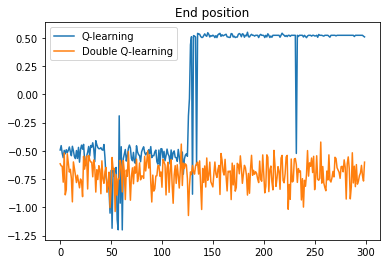

In [37]:
# Plot percentage actions left over episodes:
plt.plot(q_data_pos.mean(0), label='Q-learning')
plt.plot(dq_data_pos.mean(0), label='Double Q-learning')
plt.title('End position')
plt.legend()
plt.show()